In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import catboost

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool


from xgboost import XGBClassifier
import xgboost as xgb

#imports for plotting trees
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

In [2]:
# Read csv file
#path = "csv\\mldata_v2.csv"
path = "csv\\mldata.csv"
df = pd.read_csv(path)
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav_1,66150,0.335555,0.090997,0.130189,0.003559,1773.358004,169450.829707,1972.334258,117272.640573,...,39.547077,-3.230046,36.606857,0.696385,37.766136,-5.035945,33.668550,-0.239585,43.818886,blues
1,blues.00000.wav_2,66150,0.343523,0.086782,0.112119,0.001491,1817.244034,90766.297514,2010.751494,65940.666037,...,64.819780,-6.025473,40.548813,0.127131,51.048943,-2.808956,97.221504,5.771881,60.360348,blues
2,blues.00000.wav_3,66150,0.347746,0.092495,0.130895,0.004552,1790.722358,110071.206762,2088.184750,73391.498088,...,68.306790,-1.714475,28.136944,2.329553,47.211426,-1.925621,52.922430,2.466996,33.163998,blues
3,blues.00000.wav_4,66150,0.363863,0.087207,0.131349,0.002338,1660.545231,109496.936309,1967.920582,79805.901501,...,48.543200,-3.786986,28.419546,1.153315,35.682700,-3.501979,50.610344,3.580636,32.325880,blues
4,blues.00000.wav_5,66150,0.335481,0.088482,0.142370,0.001734,1634.465076,77425.419156,1954.633566,57359.695597,...,30.829544,0.635798,44.645557,1.591107,51.415867,-3.364908,26.421090,0.501504,29.109533,blues


In [3]:
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [4]:
df.shape[1]

60

## Preprocessing for machine learning

In [5]:
# Define features set. Dropping filename, length and label
X = df.copy()
X.drop(["filename", "length", "label"], axis=1, inplace=True)
#Converting X to numpy array as a part of preprocessing
X.to_numpy()

array([[ 3.3555517e-01,  9.0996690e-02,  1.3018920e-01, ...,
         3.3668550e+01, -2.3958503e-01,  4.3818886e+01],
       [ 3.4352323e-01,  8.6782290e-02,  1.1211886e-01, ...,
         9.7221504e+01,  5.7718810e+00,  6.0360348e+01],
       [ 3.4774640e-01,  9.2494520e-02,  1.3089524e-01, ...,
         5.2922430e+01,  2.4669962e+00,  3.3163998e+01],
       ...,
       [ 3.4781490e-01,  8.9140065e-02,  5.1905760e-02, ...,
         4.7727330e+01, -2.1486863e-01,  4.1377610e+01],
       [ 3.8680053e-01,  8.4649250e-02,  6.5967320e-02, ...,
         2.4930906e+01,  6.6620857e-01,  1.2577226e+01],
       [ 3.6872125e-01,  8.6581630e-02,  5.0242780e-02, ...,
         3.8876560e+01, -3.4117005e+00,  3.1680986e+01]])

In [6]:
# Define target vector "label"
y = df["label"].to_numpy()
y[:5]

array(['blues', 'blues', 'blues', 'blues', 'blues'], dtype=object)

## Decision Trees

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [8]:
#Decision tree
model_Dtree = DecisionTreeClassifier(
    #I added entropy and it increased the result. Trimming leafs, editing max_depth did not improve the accuracy
    criterion="entropy", 
)
model_Dtree.fit(X_train, y_train)

y_pred = model_Dtree.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       blues       0.69      0.66      0.67       250
   classical       0.87      0.85      0.86       250
     country       0.51      0.52      0.52       249
       disco       0.58      0.62      0.60       250
      hiphop       0.65      0.68      0.66       250
        jazz       0.70      0.67      0.68       247
       metal       0.80      0.85      0.83       250
         pop       0.79      0.69      0.73       250
      reggae       0.62      0.66      0.64       250
        rock       0.49      0.47      0.48       250

    accuracy                           0.67      2496
   macro avg       0.67      0.67      0.67      2496
weighted avg       0.67      0.67      0.67      2496



In [9]:
# Calculate confusion matrix. AI helped me to modify confusion matrix from my original
cm = confusion_matrix(y_test, y_pred)

# Use unique class labels for the confusion matrix
class_labels = sorted(set(y)) 
cm_df = pd.DataFrame(cm, index=[f"{label}" for label in class_labels], 
                         columns=[f"Predicted {label}" for label in class_labels])

# Confusion matrix
print("Confusion Matrix for Decision Trees:")
cm_df.head(11)

Confusion Matrix for Decision Trees:


,Predicted blues,Predicted classical,Predicted country,Predicted disco,Predicted hiphop,Predicted jazz,Predicted metal,Predicted pop,Predicted reggae,Predicted rock
blues,164,1,13,10,8,9,9,2,16,18
classical,3,213,9,2,1,14,0,1,1,6
country,28,2,130,10,6,22,1,11,19,20
disco,10,2,14,156,20,1,7,9,12,19
hiphop,8,0,4,18,169,3,7,12,23,6
jazz,11,20,20,2,3,166,5,1,6,13
metal,5,1,3,8,8,3,213,1,0,8
pop,0,1,12,16,20,5,0,172,10,14
reggae,4,1,23,12,17,2,2,5,166,18
rock,6,4,27,35,8,13,22,5,13,117


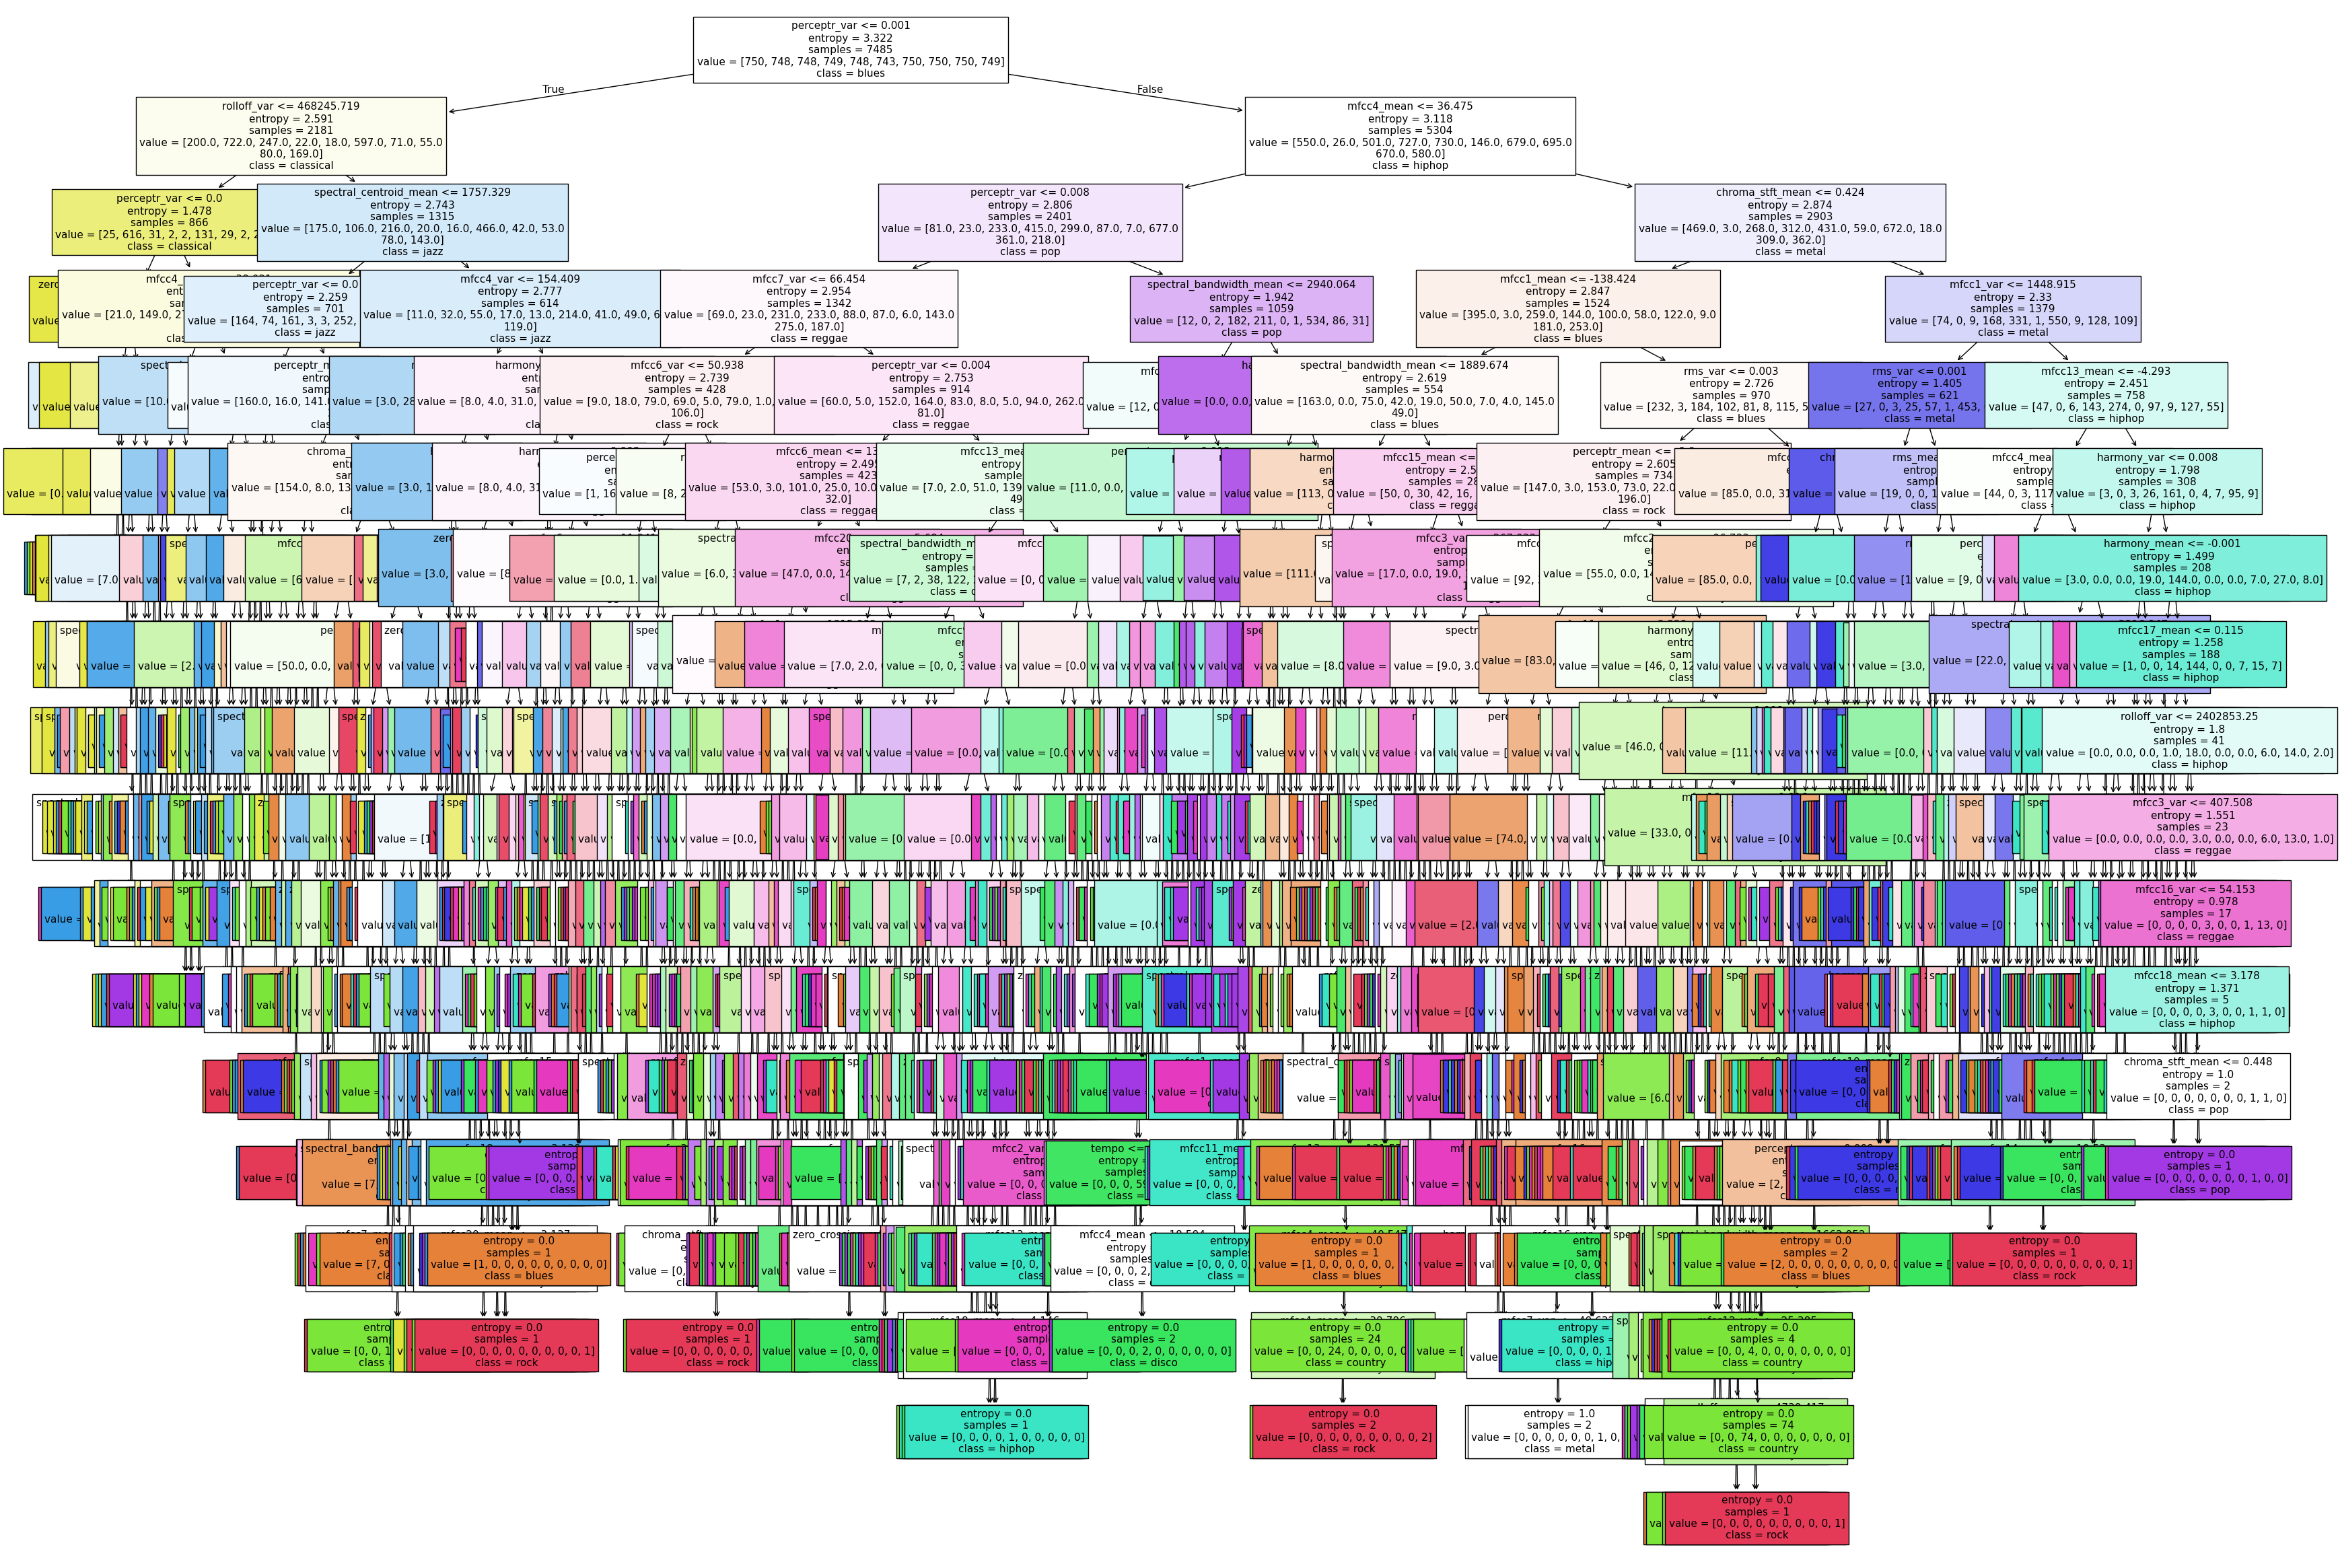

In [11]:
# Plot the decision tree

#Explicitly defining features and classes
feature_names = df.drop(["filename", "length", "label"], axis=1).columns.tolist()
class_names = list(df["label"].unique())

#Ploting the tree
plt.figure(figsize=(40, 30))
plot_tree(
    model_Dtree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    fontsize = 11
)

# Saving the plot with higher resolution. 
plt.savefig('Plots/decision_tree.png', dpi=500, bbox_inches='tight')

# Displaying the plot
plt.show()

## Implementing Random Forest

In [161]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [162]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, criterion="entropy", random_state=42)

In [163]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

In [164]:
y_pred = rf_model.predict(X_test)

In [165]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       blues       0.91      0.87      0.89       250
   classical       0.91      0.96      0.93       250
     country       0.81      0.87      0.84       249
       disco       0.85      0.87      0.86       250
      hiphop       0.95      0.88      0.92       250
        jazz       0.86      0.88      0.87       247
       metal       0.87      0.96      0.91       250
         pop       0.93      0.88      0.91       250
      reggae       0.84      0.89      0.87       250
        rock       0.89      0.73      0.80       250

    accuracy                           0.88      2496
   macro avg       0.88      0.88      0.88      2496
weighted avg       0.88      0.88      0.88      2496



In [166]:
# Calculate confusion matrix. AI helped me to modify confusion matrix from my original
cm = confusion_matrix(y_test, y_pred)

# Use unique class labels for the confusion matrix
class_labels = sorted(set(y)) 
cm_df = pd.DataFrame(cm, index=[f"{label}" for label in class_labels], 
                         columns=[f"Predicted {label}" for label in class_labels])

# Confusion matrix
print("Confusion Matrix for Random Forest:")
cm_df.head(11)

Confusion Matrix for Random Forest:


,Predicted blues,Predicted classical,Predicted country,Predicted disco,Predicted hiphop,Predicted jazz,Predicted metal,Predicted pop,Predicted reggae,Predicted rock
blues,218,2,9,3,1,2,10,0,4,1
classical,0,239,3,0,0,6,0,0,1,1
country,9,1,216,3,0,8,0,3,8,1
disco,1,1,6,217,5,0,5,1,5,9
hiphop,0,1,1,4,221,2,2,7,11,1
jazz,5,17,5,1,0,218,0,0,0,1
metal,0,1,1,0,1,0,241,0,2,4
pop,0,1,5,9,2,2,0,220,8,3
reggae,3,1,5,4,1,6,0,5,223,2
rock,3,0,17,14,2,10,19,0,3,182


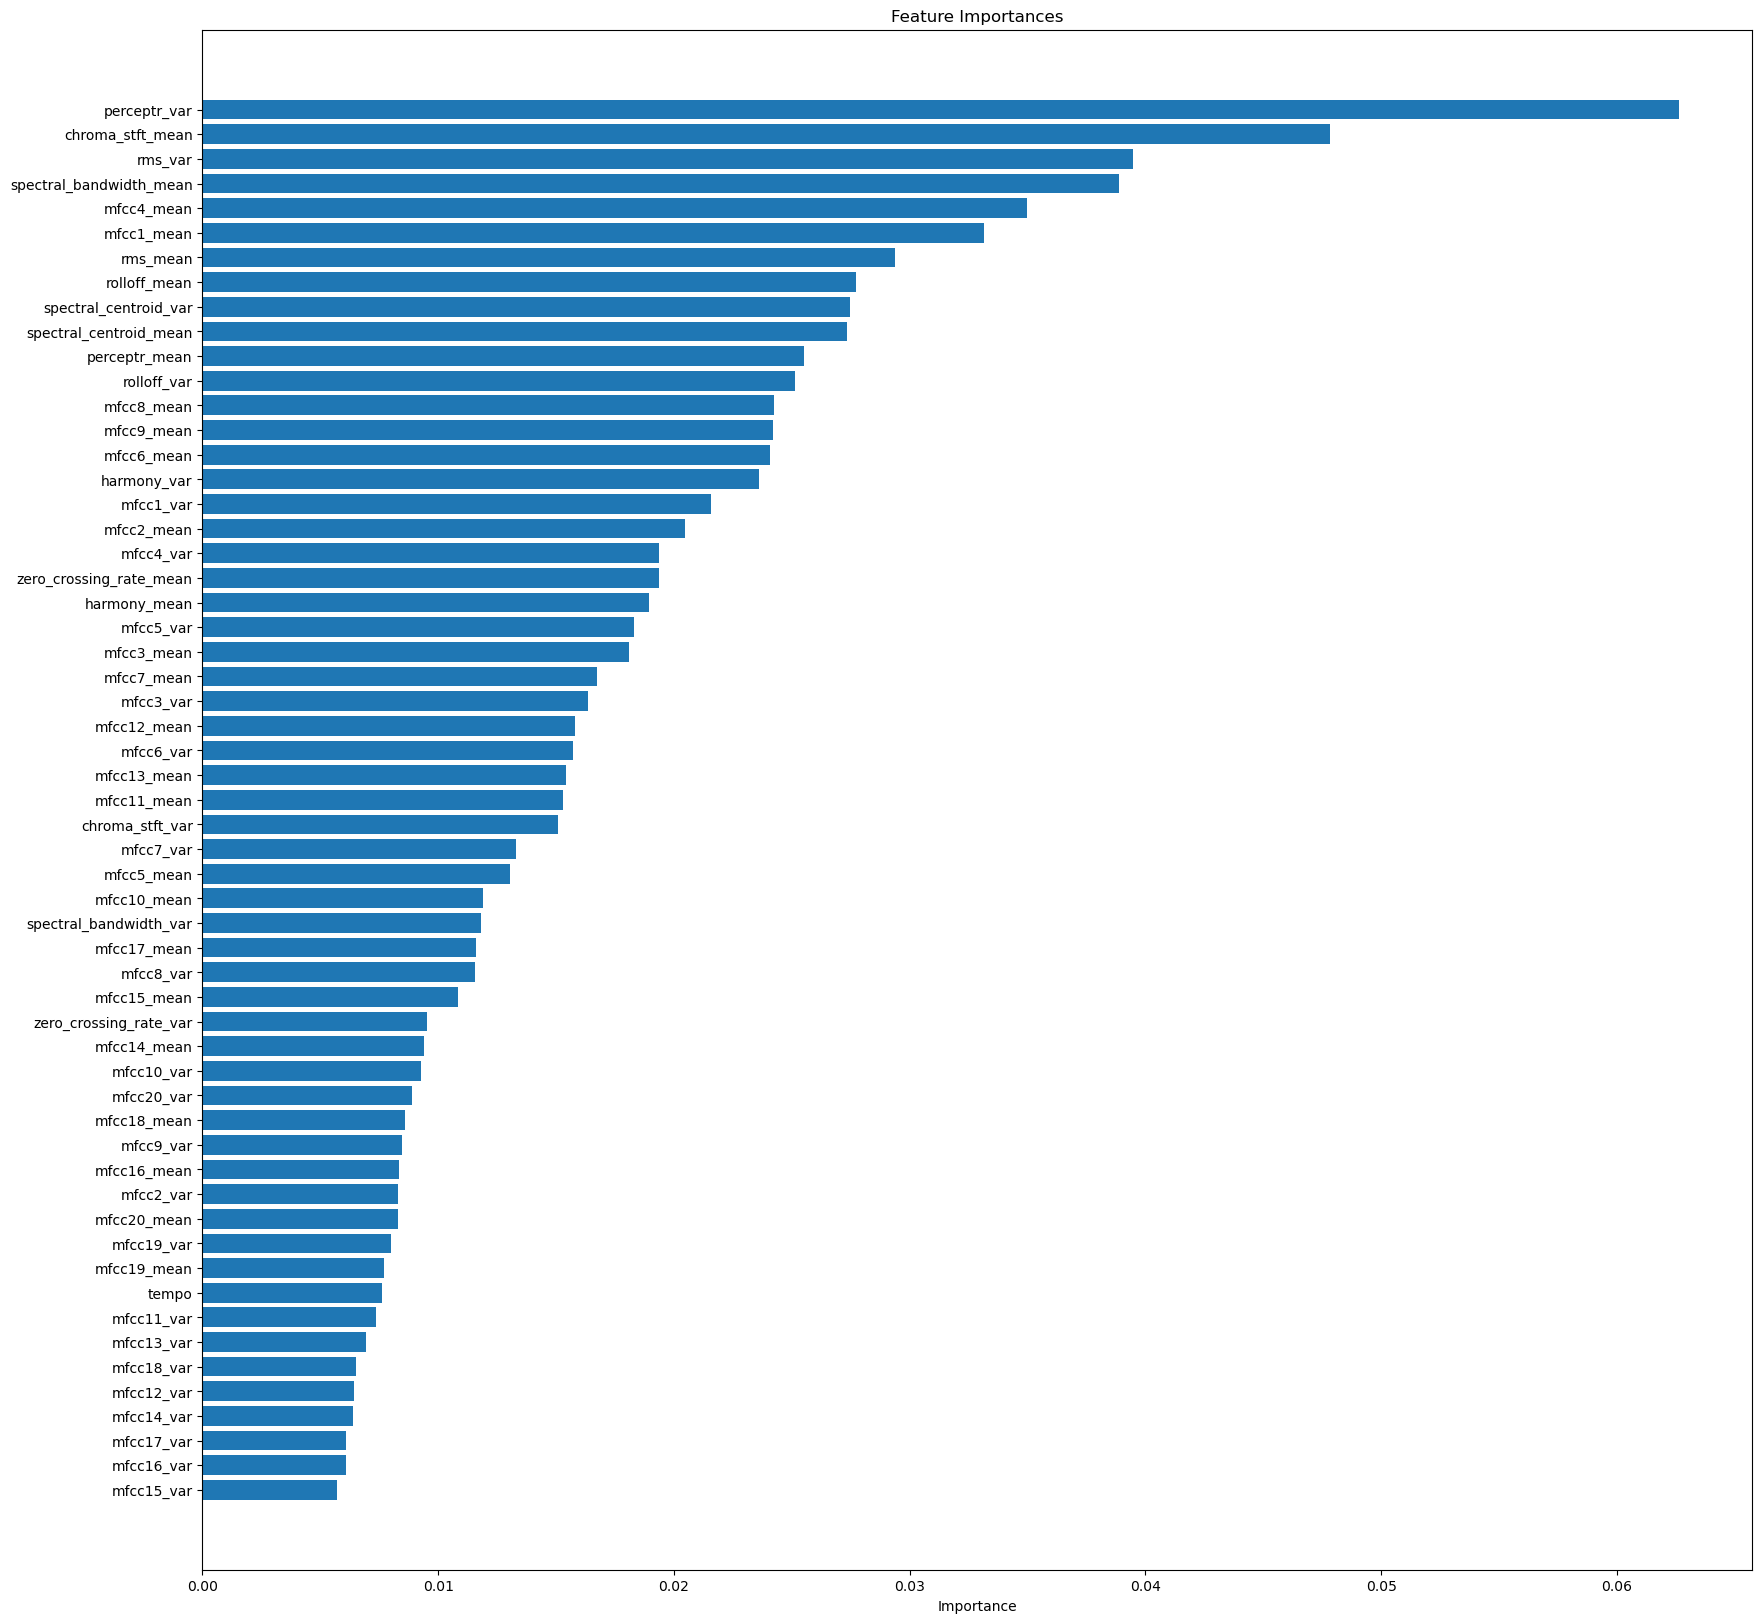

In [167]:
# Get the feature importances
importances = rf_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)

# Plot the feature importances
plt.figure(figsize=(20, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel('Importance')
plt.show()

## Trying XGBoost

In [168]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [169]:

#Labels of music genres should be converted to integers for this algorithm
#Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [170]:
# Train the XGBoost model
XGB_model = XGBClassifier(n_estimators=1000, random_state=42)
XGB_model.fit(X_train, y_train_encoded)

# Make predictions
predictions = XGB_model.predict(X_test)

# Decode the predictions back to original labels
predict_decoded = label_encoder.inverse_transform(predictions)

# Evaluate the model
print(classification_report(y_test, predict_decoded))

              precision    recall  f1-score   support

       blues       0.91      0.89      0.90       250
   classical       0.92      0.96      0.94       250
     country       0.84      0.86      0.85       249
       disco       0.90      0.90      0.90       250
      hiphop       0.94      0.93      0.93       250
        jazz       0.90      0.88      0.89       247
       metal       0.93      0.95      0.94       250
         pop       0.93      0.92      0.93       250
      reggae       0.89      0.90      0.90       250
        rock       0.92      0.86      0.89       250

    accuracy                           0.91      2496
   macro avg       0.91      0.91      0.91      2496
weighted avg       0.91      0.91      0.91      2496



In [171]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, predict_decoded)

# Use unique class labels for the confusion matrix
class_labels = sorted(set(y_test)) 
cm_df = pd.DataFrame(cm, index=[f"{label}" for label in class_labels], 
                         columns=[f"Predicted {label}" for label in class_labels])

# Confusion matrix
print("Confusion Matrix for XGBoost:")
cm_df.head(11)

Confusion Matrix for XGBoost:


,Predicted blues,Predicted classical,Predicted country,Predicted disco,Predicted hiphop,Predicted jazz,Predicted metal,Predicted pop,Predicted reggae,Predicted rock
blues,223,1,11,1,2,2,5,0,3,2
classical,1,241,2,0,0,5,0,1,0,0
country,11,1,215,2,1,8,0,3,5,3
disco,2,1,2,225,6,1,4,3,4,2
hiphop,0,0,2,1,232,2,2,3,8,0
jazz,2,13,9,3,0,218,0,0,2,0
metal,2,1,2,1,1,0,238,0,0,5
pop,0,1,3,6,2,1,0,229,3,5
reggae,1,1,3,6,1,3,0,6,226,3
rock,4,2,8,6,2,2,6,0,4,216


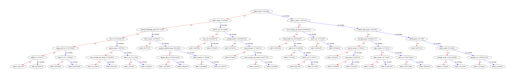

In [172]:
#Plot the first tree
xgb.plot_tree(XGB_model, num_trees=0)

#Save the png
plt.savefig('Plots/XGBoost_first_tree.png', dpi=500, bbox_inches='tight')

# Show the plot
plt.show()

## Multinomial Logistical Regresstion 

In [173]:
#Encode y labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [174]:
#Split the data, stratify y_encoded for balanced splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [175]:
#This time scaling the data for logistical regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [176]:
#Using logistical regression
log_reg_model = LogisticRegression(solver='lbfgs', max_iter=500)

log_reg_model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=500)

In [177]:
#Predict on test data
prediction = log_reg_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, prediction)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.72


In [178]:
#Classification report
print(classification_report(y_test, prediction, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       blues       0.70      0.71      0.70       200
   classical       0.89      0.94      0.91       200
     country       0.62      0.58      0.60       199
       disco       0.66      0.67      0.66       200
      hiphop       0.80      0.64      0.71       200
        jazz       0.76      0.81      0.79       198
       metal       0.77      0.88      0.82       200
         pop       0.79      0.79      0.79       200
      reggae       0.67      0.68      0.67       200
        rock       0.51      0.48      0.50       200

    accuracy                           0.72      1997
   macro avg       0.72      0.72      0.72      1997
weighted avg       0.72      0.72      0.72      1997



## CatBoost

In [179]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [180]:
# Train CatBoost Model
catboost_model = CatBoostClassifier(
    iterations=1000,       
    learning_rate=0.1,    
    depth=6,                  
    loss_function='MultiClass',
    random_seed=42,     
    verbose=50    
)

catboost_model.fit(X_train, y_train)

0:	learn: 2.1422955	total: 117ms	remaining: 1m 57s
50:	learn: 0.8407516	total: 5.25s	remaining: 1m 37s
100:	learn: 0.5932955	total: 10.4s	remaining: 1m 32s
150:	learn: 0.4539999	total: 15.7s	remaining: 1m 28s
200:	learn: 0.3666588	total: 20.8s	remaining: 1m 22s
250:	learn: 0.3102314	total: 25.9s	remaining: 1m 17s
300:	learn: 0.2678361	total: 31s	remaining: 1m 11s
350:	learn: 0.2328331	total: 36s	remaining: 1m 6s
400:	learn: 0.2046977	total: 41s	remaining: 1m 1s
450:	learn: 0.1807007	total: 46s	remaining: 56s
500:	learn: 0.1622655	total: 51.3s	remaining: 51.1s
550:	learn: 0.1441710	total: 56.4s	remaining: 46s
600:	learn: 0.1303342	total: 1m 1s	remaining: 40.8s
650:	learn: 0.1179174	total: 1m 6s	remaining: 35.6s
700:	learn: 0.1066728	total: 1m 11s	remaining: 30.6s
750:	learn: 0.0976622	total: 1m 17s	remaining: 25.5s
800:	learn: 0.0875830	total: 1m 22s	remaining: 20.4s
850:	learn: 0.0805214	total: 1m 27s	remaining: 15.3s
900:	learn: 0.0743081	total: 1m 37s	remaining: 10.7s
950:	learn: 0.0

In [181]:
# Predict the model
y_pred = catboost_model.predict(X_test)
# Accuracy and the classification report
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy on Test Set: 0.9158653846153846
Classification Report:
               precision    recall  f1-score   support

       blues       0.91      0.92      0.92       257
   classical       0.95      0.98      0.96       255
     country       0.89      0.88      0.89       240
       disco       0.88      0.88      0.88       247
      hiphop       0.94      0.91      0.93       279
        jazz       0.90      0.91      0.90       234
       metal       0.94      0.95      0.95       270
         pop       0.93      0.93      0.93       249
      reggae       0.92      0.92      0.92       239
        rock       0.91      0.86      0.88       226

    accuracy                           0.92      2496
   macro avg       0.91      0.91      0.91      2496
weighted avg       0.92      0.92      0.92      2496



In [182]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Use unique class labels for the confusion matrix
class_labels = sorted(set(y_test)) 
cm_df = pd.DataFrame(cm, index=[f"{label}" for label in class_labels], 
                         columns=[f"Predicted {label}" for label in class_labels])

# Confusion matrix
print("Confusion Matrix for XGBoost:")
cm_df.head(11)

Confusion Matrix for XGBoost:


,Predicted blues,Predicted classical,Predicted country,Predicted disco,Predicted hiphop,Predicted jazz,Predicted metal,Predicted pop,Predicted reggae,Predicted rock
blues,237,1,4,4,2,3,2,0,3,1
classical,0,250,0,0,0,5,0,0,0,0
country,9,0,212,2,0,8,0,3,3,3
disco,5,0,4,217,7,1,0,7,2,4
hiphop,1,1,5,4,255,1,2,5,5,0
jazz,4,9,5,0,0,213,0,2,0,1
metal,1,0,0,2,1,1,257,0,0,8
pop,0,1,5,5,3,2,0,231,1,1
reggae,1,0,2,9,3,1,0,1,220,2
rock,3,2,2,5,0,2,12,0,6,194


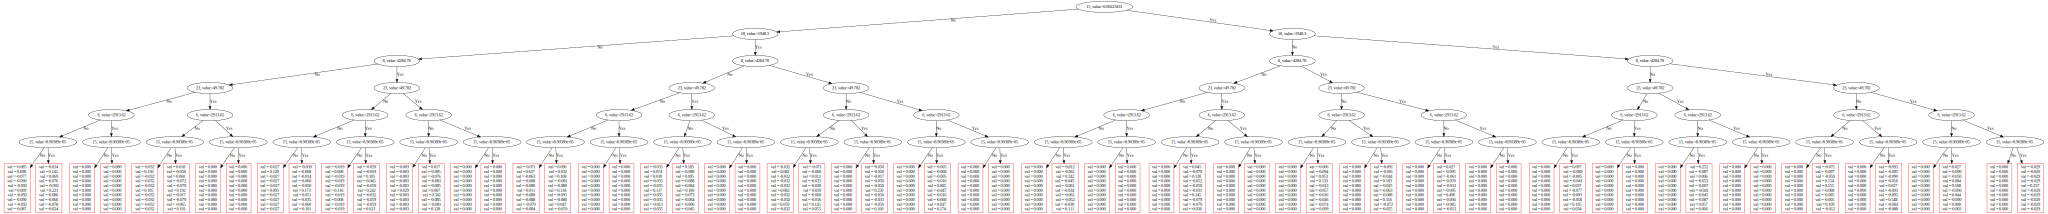

In [183]:
#Plot first tree of Cat Boost Model
catboost_model.plot_tree(tree_idx=0)


## Testing of audio files with librosa library was made with Chat GPT assistance

In [184]:
#Test audio file
def extract_features(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, duration=30)

    # Extract features in the same order as in training
    chroma_stft_mean = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    chroma_stft_var = np.var(librosa.feature.chroma_stft(y=y, sr=sr))

    rms_mean = np.mean(librosa.feature.rms(y=y))
    rms_var = np.var(librosa.feature.rms(y=y))

    spectral_centroid_mean = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_centroid_var = np.var(librosa.feature.spectral_centroid(y=y, sr=sr))

    spectral_bandwidth_mean = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_bandwidth_var = np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr))

    rolloff_mean = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    rolloff_var = np.var(librosa.feature.spectral_rolloff(y=y, sr=sr))

    zero_crossing_rate_mean = np.mean(librosa.feature.zero_crossing_rate(y=y))
    zero_crossing_rate_var = np.var(librosa.feature.zero_crossing_rate(y=y))

    harmony = librosa.effects.harmonic(y)
    harmony_mean = np.mean(harmony)
    harmony_var = np.var(harmony)

    perceptr = librosa.effects.percussive(y)
    perceptr_mean = np.mean(perceptr)
    perceptr_var = np.var(perceptr)

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_var = np.var(mfccs, axis=1)

    # Combine all features into a single feature vector
    features = np.hstack((
        chroma_stft_mean, chroma_stft_var,
        rms_mean, rms_var,
        spectral_centroid_mean, spectral_centroid_var,
        spectral_bandwidth_mean, spectral_bandwidth_var,
        rolloff_mean, rolloff_var,
        zero_crossing_rate_mean, zero_crossing_rate_var,
        harmony_mean, harmony_var,
        perceptr_mean, perceptr_var,
        tempo,
        mfccs_mean, mfccs_var
    ))

    # Print features for debugging
    print("Extracted Features:", features)

    return features


# Test the function

#file_path = "Resources/GTZAN/Music_files/disco.00005.wav"
#file_path = "Resources/GTZAN/Music_files/rock.00005.wav"
#file_path = "Resources/GTZAN/Music_files/classical.00005.wav"
#file_path = "Resources/GTZAN/Music_files/pop.00005.wav"
file_path = "Resources/GTZAN/Music_files/hiphop.00005.wav"
test_features = extract_features(file_path)

Extracted Features: [ 4.90667313e-01  8.14223811e-02  2.61673719e-01  5.38808526e-03
  2.70896137e+03  2.48191459e+05  2.51090241e+03  4.85303238e+04
  5.79510662e+03  4.93283873e+05  1.24614137e-01  2.61332564e-03
 -2.85360758e-04  3.25349942e-02 -2.89703161e-03  1.88680068e-02
  7.17773438e+01 -1.16755075e+01  8.19932480e+01 -8.50569725e+00
  5.27678261e+01 -1.47042198e+01  3.19647350e+01 -1.96899986e+01
  2.28694267e+01 -1.47106476e+01  1.45188112e+01 -1.00830784e+01
  1.40050716e+01 -8.07301331e+00  7.43421364e+00 -5.49781513e+00
  1.28421764e+01 -3.69733596e+00  6.21795845e+00 -2.59025145e+00
  1.05407983e-01  1.34911279e+03  3.85396332e+02  2.38736801e+02
  2.32358841e+02  1.53807510e+02  1.05960838e+02  1.15261322e+02
  8.82033997e+01  6.16255455e+01  8.11273117e+01  7.67177582e+01
  6.65447159e+01  5.20571442e+01  4.34075356e+01  3.93735504e+01
  4.33456497e+01  4.18900490e+01  4.50959702e+01  3.82146568e+01
  4.12258415e+01]


In [185]:
#Testing audio file on Random Forest

# Check the number of features
if len(test_features) < rf_model.n_features_in_:
    # Add a placeholder for the missing feature
    missing_features = rf_model.n_features_in_ - len(test_features)
    test_features = np.append(test_features, [0] * missing_features)
elif len(test_features) > rf_model.n_features_in_:
    # Trim extra features
    test_features = test_features[:rf_model.n_features_in_]

# Step 3: Reshape for prediction
test_features = test_features.reshape(1, -1)

# Step 4: Make prediction
prediction = rf_model.predict(test_features)

print(f"Predicted genre: {prediction[0]}")

Predicted genre: pop


c:\Users\masce\anaconda3\envs\dev\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [186]:
#Test audio file on CatBoost Model
# Check the number of features
if len(test_features) < catboost_model.n_features_in_:
    # Add a placeholder for the missing feature
    missing_features = catboost_model.n_features_in_ - len(test_features)
    test_features = np.append(test_features, [0] * missing_features)
elif len(test_features) > catboost_model.n_features_in_:
    # Trim extra features
    test_features = test_features[:catboost_model.n_features_in_]

# Step 3: Reshape for prediction
test_features = test_features.reshape(1, -1)

# Step 4: Make prediction
prediction = catboost_model.predict(test_features)

print(f"Predicted genre: {prediction[0]}")


Predicted genre: ['pop']
